# Group Project: Movie Recommendations (2487-T2 Machine Learning) [Group 2]
- Nova School of Business and Economics, Portugal
- Instructor: Qiwei Han, Ph.D.
- Program: Masters Program in Business Analytics
- Group Members: 
    - **Luca Silvano Carocci (53942)**
    - **Fridtjov Höyerholt Stokkeland (52922)**
    - **Diego García Rieckhof (53046)**
    - **Matilde Pesce (53258)**
    - **Florian Fritz Preiss (54385)**<br>
---

# Phase 6: Deployment [07 Showcase Notebook]


## **Deployment of Content-Based Recommender Model on Streamify Movie Streaming Platform**

This Machine Learning project presents a series of showcase notebooks designed for A/B testing in the context of model evaluation (refer to Notebook: 06_model-evaluation). These notebooks enable the collection of user feedback based on interactions with our recommender system and user responses to film recommendations. The primary objective of following notebook is to demonstrate the application of an content-based recommender model within the Streamify Movie Streaming Platform, offering personalized recommendations to users regardless of their status as existing or new subscribers.

To achieve this aim, we have replicated the interface of the Streamify Movie Streaming Platform within the notebook and presented three distinct scenarios:

- Scenario A: An existing user logs into the platform (userID ranging from 1 to 162,541).
- Scenario B: A new user logs into the platform (userID exceeding 162,541).
- Scenario C: The user obtains personalized movie suggestions by manually inputting movie titles. The system accounts for potential spelling errors by employing a similarity function to correct inaccuracies.

By employing this showcase notebooks, we intend to thoroughly evaluate the effectiveness of the content-based recommender model, ensuring that the Streamify Movie Streaming Platform delivers an optimal user experience through tailored recommendations.

In [1]:
# Standard library imports
import pickle
import time
import warnings

# Third-party imports
import numpy as np
import pandas as pd
from IPython.display import display, HTML
from fuzzywuzzy import fuzz

# Local application imports
from recommender import ContentRecommenderTFIDFOptimized

# Ignore warnings
warnings.filterwarnings("ignore")

In [2]:
# Load movies dataset
movies_df = pd.read_csv('../00_Data/02_engineered/movies_df_engineered.csv', dtype={'movieId': int})
movies_df.head(2)

,movieId,title,movie_age,genres,combined_text,vote_average,vote_count,score,sentiment
0,1,Toy Story (1995),28,"['Adventure', 'Animation', 'Children', 'Comedy...",adventure animation children comedy fantasy re...,3.893708,57309.0,3.883305,0.112121
1,2,Jumanji (1995),28,"['Adventure', 'Children', 'Fantasy']",adventure children fantasy adaptationofbook ad...,3.251527,24228.0,3.242912,-0.218750


In [3]:
# Load ratings dataset
ratings_df = pd.read_csv('../00_Data/01_processed/prepr_ratings.csv', dtype={'userId': object, 'movieId': int})
ratings_df['timestamp'] = pd.to_datetime(ratings_df['timestamp'], unit='s', origin='unix')
ratings_df = ratings_df.drop('Unnamed: 0', axis=1)
ratings_df.head(2)

,userId,movieId,rating,timestamp
0,1,296,5.0,2006-05-17 15:34:04
1,1,306,3.5,2006-05-17 12:26:57


**Load content-based recommender model (TF-IDF Vectorizer Optimized)**

In [4]:
# Load the saved model
with open('../02_Models/content_recommender_tfidf.pkl', 'rb') as file:
    recommender = pickle.load(file)

**Define functions for recommendations**

In [5]:
def get_combined_movie_recommendations(user_id, ratings_df, recommender, top_n=10):

    last_three_movies = ratings_df[ratings_df['userId'] == user_id].sort_values(by=['rating', 'timestamp'], ascending=False).iloc[:3, 1]

    user_recommendations = []

    for movie_id in last_three_movies:

        if movie_id in recommender.movies_df['movieId'].values:

            movie_title = recommender.movies_df[recommender.movies_df['movieId'] == movie_id]['title'].iloc[0]

            recommendations = recommender.recommend(movie_id, top_n=top_n)

            user_recommendations.append(recommendations)

        else:

            print(f"Movie ID {movie_id} not found in the movies dataset. Skipping...")

    # Combine the recommendations of the three movies and select the top 10 based on the combined_score
    combined_recommendations = pd.concat(user_recommendations).drop_duplicates(subset=['title']).nlargest(top_n, 'combined_score')

    return combined_recommendations

In [6]:
def get_single_movie_recommendations(user_id, ratings_df, recommender, top_n=10):
    last_three_movies = ratings_df[ratings_df['userId'] == user_id].sort_values(by=['rating', 'timestamp'], ascending=False).iloc[:3, 1]
    user_recommendations = {}
    
    for movie_id in last_three_movies:
        if movie_id in recommender.movies_df['movieId'].values:
            movie_title = recommender.movies_df[recommender.movies_df['movieId'] == movie_id]['title'].iloc[0]
            recommendations = recommender.recommend(movie_id, top_n=top_n)
            user_recommendations[movie_title] = recommendations
        else:
            print(f"Movie ID {movie_id} not found in the movies dataset. Skipping...")
    
    return user_recommendations

In [7]:
def matching_score(a, b):
    return fuzz.ratio(a, b)

def get_title_from_index(index, movies_df):
    return movies_df[movies_df.index == index]['title'].values[0]

def get_index_from_title(title, movies_df):
    return movies_df[movies_df.title == title].index.values[0]

def find_closest_title(title, movies_df):
    leven_scores = list(enumerate(movies_df['title'].apply(matching_score, b=title)))
    sorted_leven_scores = sorted(leven_scores, key=lambda x: x[1], reverse=True)
    closest_title = get_title_from_index(sorted_leven_scores[0][0], movies_df)
    distance_score = sorted_leven_scores[0][1]
    return closest_title, distance_score

In [8]:
def get_recommendations_by_title(movie_title, recommender, top_n=10):
    closest_title, distance_score = find_closest_title(movie_title, recommender.movies_df)
    movie_id = recommender.movies_df[recommender.movies_df['title'] == closest_title]['movieId'].values[0]

    recommendations = recommender.recommend(movie_id, top_n=top_n)

    if distance_score < 100:
        # Print the recommendations
        print(f"\n\nDid you mean '{closest_title}'?\n")
        print(f"Recommendations based on the movie '{closest_title}':\n")
    
    else:
        # Print the recommendations
        print(f"\n\nRecommendations based on the movie '{movie_title}':\n")

    return recommendations

In [9]:
def display_recommendations(df):
    # Define the CSS style for the table
    css_style = '''
    <style>
        table {
            border-collapse: collapse;
            width: 100%;
        }
        th, td {
            border: 1px solid #ddd;
            padding: 8px;
            text-align: left;
        }
        th {
            background-color: #f2f2f2;
            font-weight: bold;
        }
        tr:nth-child(even) {
            background-color: #f2f2f2;
        }
        tr:hover {
            background-color: #ddd;
        }
    </style>
    '''
    
    # Convert the DataFrame to an HTML table
    html_table = df.to_html(index=False)

    # Combine the CSS style and the HTML table
    styled_html_table = css_style + html_table

    # Display the styled HTML table
    display(HTML(styled_html_table))

---
# **User Interface of CineSphere Streaming Platform**

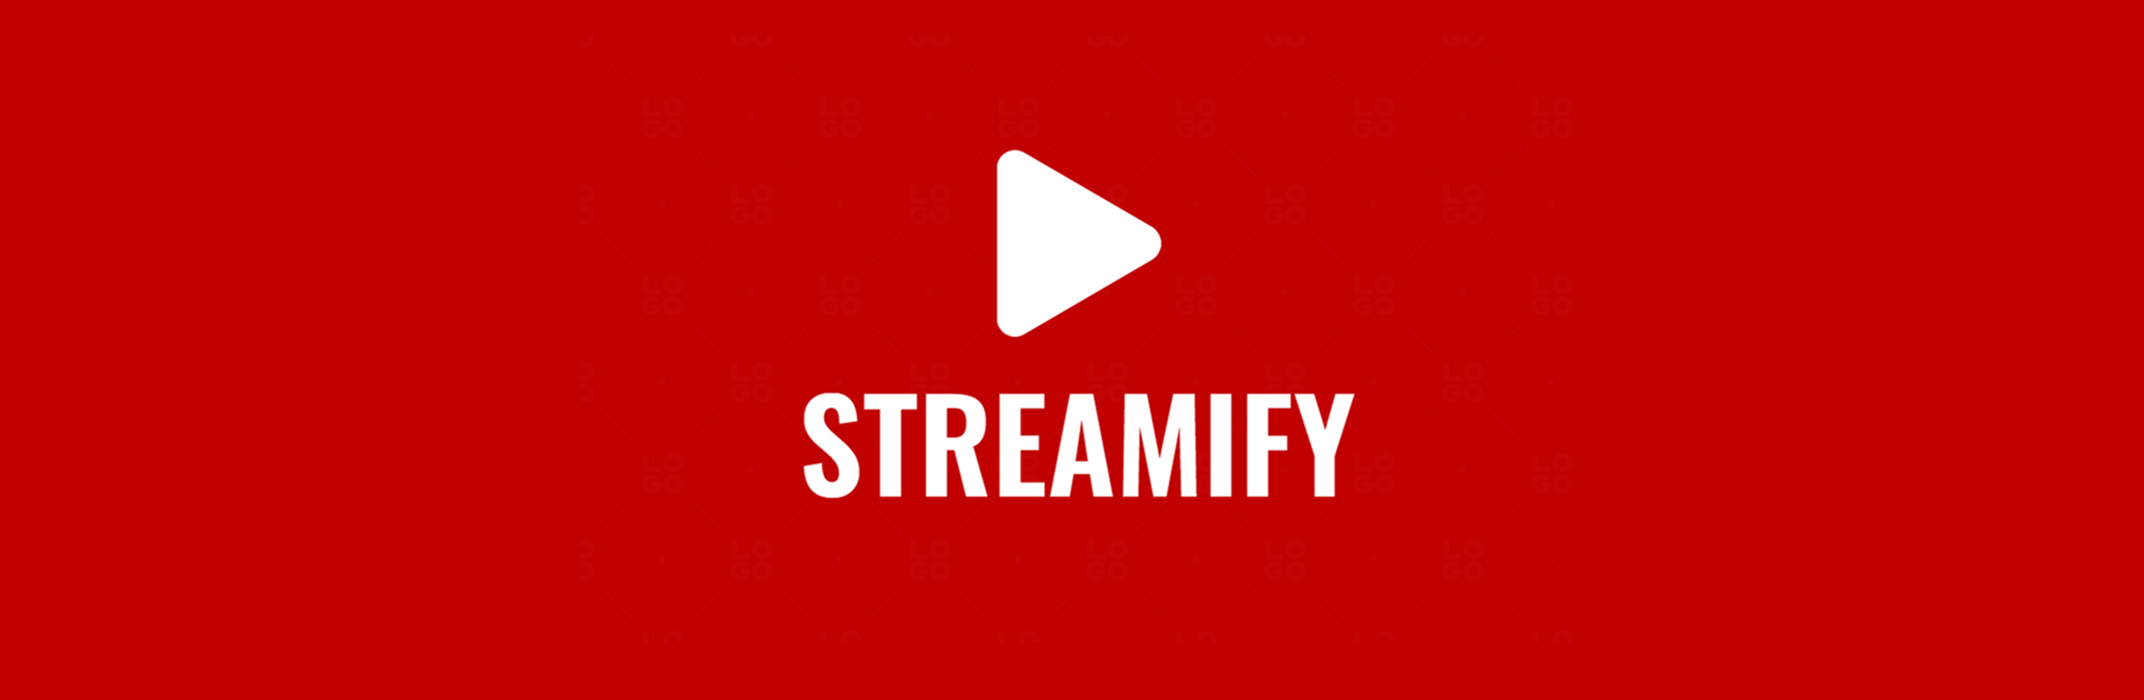

In [10]:
# Calculate the minimum and maximum user IDs in the ratings DataFrame
user_min = ratings_df['userId'].astype(int).min()
user_max = ratings_df['userId'].astype(int).max()

# Print the user base range and recommendations
print(f"\nThe user base of the Streamify Movie Streaming Platform ranges from {user_min} to {user_max}.")
print("\nIf you enter a user ID within the user base in the input field at Recommendations For You,\n"
      "you will be logged in as an existing user and receive movie recommendations based on your last\n"
      "rated movies. If you log in with a user ID outside the user base, you will be asked for your top\n"
      "three genres and receive recommendations based on your favorite genres.\n")


The user base of the Streamify Movie Streaming Platform ranges from 1 to 162541.

If you enter a user ID within the user base in the input field at Recommendations For You,
you will be logged in as an existing user and receive movie recommendations based on your last
rated movies. If you log in with a user ID outside the user base, you will be asked for your top
three genres and receive recommendations based on your favorite genres.



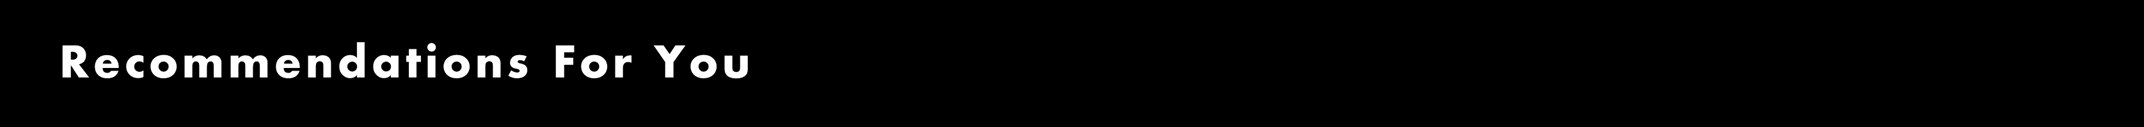

**Scenario A: A registered user of Streamify logs in (userID is between 1 and 162541)**

In [11]:
# Function to extract all unique genres from movies_df
def get_all_genres(movies_df):
    all_genres = set()
    for genres in movies_df['genres']:
        genre_list = genres[1:-1].replace("'", "").split(', ')
        all_genres.update(genre_list)
    # Exclude the '(no genres listed)' genre
    all_genres.discard('(no genres listed)')
    return sorted(list(all_genres))

# Get user_id from input
user_id = input("Please enter your user ID: ")

if user_id not in ratings_df['userId'].unique():
    # Simulate new user
    print(f"\n\nWelcome to Streamify, user {user_id}!\n\n")
    
    # Print all available genres
    all_genres = get_all_genres(movies_df)
    print("Here are all the available genres:")
    print(", ".join(all_genres))
    
    favorite_genres = input("\nPlease enter your top three favorite genres separated by commas: ")
    favorite_genres = [genre.strip() for genre in favorite_genres.split(',')]
    
    # Print top-ten movie recommendation list that combines all favorite genres
    combined_genre_recommendations = movies_df[movies_df['genres'].str.contains(favorite_genres[0])]
    for genre in favorite_genres[1:]:
        combined_genre_recommendations = combined_genre_recommendations[combined_genre_recommendations['genres'].str.contains(genre)]
    combined_genre_recommendations = combined_genre_recommendations.nlargest(10, 'score')[['title', 'score']]
    combined_genre_recommendations = combined_genre_recommendations.rename(columns={'title': 'Movie Title', 'score': 'Estimated Rating'})
    combined_genre_recommendations['Your Personal Fit'] = combined_genre_recommendations['Estimated Rating'].apply(lambda x: f"{x * 100:.2f}%")
    combined_genre_recommendations['Estimated Rating'] = combined_genre_recommendations['Estimated Rating'].apply(lambda x: f"{x:.2f}")

    # Print combined genre recommendations
    print(f"\n\nThese are your top movie recommendations combining all your favorite genres:\n\n")
    display_recommendations(combined_genre_recommendations[['Movie Title', 'Your Personal Fit', 'Estimated Rating']].reset_index(drop=True))

    # Get top 10 movie recommendations based on favorite genres
    for genre in favorite_genres:
        genre_recommendations = movies_df[movies_df['genres'].str.contains(genre)].nlargest(10, 'score')
        genre_recommendations = genre_recommendations[['title', 'score']]
        genre_recommendations = genre_recommendations.rename(columns={'title': 'Movie Title', 'score': 'Estimated Rating'})
        genre_recommendations['Your Personal Fit'] = genre_recommendations['Estimated Rating'].apply(lambda x: f"{x * 100:.2f}%")
        genre_recommendations['Estimated Rating'] = genre_recommendations['Estimated Rating'].apply(lambda x: f"{x:.2f}")


        # Print genre recommendations
        print(f"\n\nThese are your top movie recommendations for the genre {genre}:\n\n")
        display_recommendations(genre_recommendations[['Movie Title', 'Your Personal Fit', 'Estimated Rating']].reset_index(drop=True))

else:
    # Call get_combined_movie_recommendations function with user_id
    combined_movie_recommendations = get_combined_movie_recommendations(user_id, ratings_df, recommender)

    # Call get_single_movie_recommendations function with user_id
    single_movie_recommendations = get_single_movie_recommendations(user_id, ratings_df, recommender)

    # Print the recommendations
    print(f"\n\nWelcome back on Streamify, user {user_id}! Here are your up-to-date movie recommendations!\n\n")

    print(f"Recommendations for you\n")

    # Update column names and format combined_score as percentage for combined_movie_recommendations
    if combined_movie_recommendations is not None:
        combined_movie_recommendations = combined_movie_recommendations.rename(columns={'title': 'Movie Title', 'combined_score': 'Similarity'})
        combined_movie_recommendations['Your Personal Fit'] = combined_movie_recommendations['Similarity'].apply(lambda x: f"{x * 100:.2f}%")
        combined_movie_recommendations['Similarity'] = combined_movie_recommendations['Similarity'].apply(lambda x: f"{x:.2f}")
        
        # Reset index and display the DataFrame
        display_recommendations(combined_movie_recommendations[['Movie Title', 'Your Personal Fit', 'Similarity']].reset_index(drop=True))

    print("\n\n\n")

    for movie_title, movie_recommendations in single_movie_recommendations.items():
        print(f"Because you watched {movie_title}, you may also like..\n")

        # Update column names and format combined_score as percentage for single_movie_recommendations
        if movie_recommendations is not None:
            movie_recommendations = movie_recommendations.rename(columns={'title': 'Movie Title', 'combined_score': 'Similarity'})
            movie_recommendations['Your Personal Fit'] = movie_recommendations['Similarity'].apply(lambda x: f"{x * 100:.2f}%")
            movie_recommendations['Similarity'] = movie_recommendations['Similarity'].apply(lambda x: f"{x:.2f}")

            # Reset index and display the DataFrame
            display_recommendations(movie_recommendations[['Movie Title', 'Your Personal Fit', 'Similarity']].reset_index(drop=True))

        print("\n")

Please enter your user ID:  12345




Welcome back on Streamify, user 12345! Here are your up-to-date movie recommendations!


Recommendations for you



Movie Title,Your Personal Fit,Similarity
Schindler's List (1993),98.08%,0.98
Team America: World Police (2004),93.84%,0.94
Big Fish (2003),88.56%,0.89
Eternal Sunshine of the Spotless Mind (2004),85.97%,0.86
"Pianist, The (2002)",84.43%,0.84
This Is Spinal Tap (1984),77.59%,0.78
"Counterfeiters, The (Die Fälscher) (2007)",75.91%,0.76
Dumb & Dumber (Dumb and Dumber) (1994),75.62%,0.76
Grave of the Fireflies (Hotaru no haka) (1988),69.42%,0.69
Beavis and Butt-Head Do America (1996),68.24%,0.68






Because you watched South Park: Bigger, Longer and Uncut (1999), you may also like..



Movie Title,Your Personal Fit,Similarity
Team America: World Police (2004),93.84%,0.94
This Is Spinal Tap (1984),77.59%,0.78
Dumb & Dumber (Dumb and Dumber) (1994),75.62%,0.76
Beavis and Butt-Head Do America (1996),68.24%,0.68
Blazing Saddles (1974),63.31%,0.63
Scream (1996),63.30%,0.63
Three Kings (1999),62.94%,0.63
Monty Python's Life of Brian (1979),57.82%,0.58
Mystery Science Theater 3000: The Movie (1996),57.57%,0.58
Billy Madison (1995),56.59%,0.57




Because you watched Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001), you may also like..



Movie Title,Your Personal Fit,Similarity
Big Fish (2003),88.56%,0.89
Eternal Sunshine of the Spotless Mind (2004),85.97%,0.86
Forrest Gump (1994),50.55%,0.51
"Princess Bride, The (1987)",47.45%,0.47
"Lord of the Rings: The Fellowship of the Ring, The (2001)",45.66%,0.46
Groundhog Day (1993),45.30%,0.45
Spirited Away (Sen to Chihiro no kamikakushi) (2001),45.18%,0.45
Brazil (1985),43.58%,0.44
Life Is Beautiful (La Vita è bella) (1997),41.69%,0.42
"Pan's Labyrinth (Laberinto del fauno, El) (2006)",41.11%,0.41




Because you watched Life Is Beautiful (La Vita è bella) (1997), you may also like..



Movie Title,Your Personal Fit,Similarity
Schindler's List (1993),98.08%,0.98
"Pianist, The (2002)",84.43%,0.84
"Counterfeiters, The (Die Fälscher) (2007)",75.91%,0.76
Grave of the Fireflies (Hotaru no haka) (1988),69.42%,0.69
"Green Mile, The (1999)",64.94%,0.65
Forrest Gump (1994),58.84%,0.59
Up (2009),54.50%,0.54
Cinema Paradiso (Nuovo cinema Paradiso) (1989),50.24%,0.50
One Flew Over the Cuckoo's Nest (1975),41.13%,0.41
Big Fish (2003),40.82%,0.41


**Scenario B: A new user with no track record logs in (userID > 162541)**

In [12]:
# Function to extract all unique genres from movies_df
def get_all_genres(movies_df):
    all_genres = set()
    for genres in movies_df['genres']:
        genre_list = genres[1:-1].replace("'", "").split(', ')
        all_genres.update(genre_list)
    # Exclude the '(no genres listed)' genre
    all_genres.discard('(no genres listed)')
    return sorted(list(all_genres))

# Get user_id from input
user_id = input("Please enter your user ID: ")

if user_id not in ratings_df['userId'].unique():
    # Simulate new user
    print(f"\n\nWelcome to Streamify, user {user_id}!\n\n")
    
    # Print all available genres
    all_genres = get_all_genres(movies_df)
    print("Here are all the available genres:")
    print(", ".join(all_genres))
    
    favorite_genres = input("\nPlease enter your top three favorite genres separated by commas: ")
    favorite_genres = [genre.strip() for genre in favorite_genres.split(',')]
    
    # Print top-ten movie recommendation list that combines all favorite genres
    combined_genre_recommendations = movies_df[movies_df['genres'].str.contains(favorite_genres[0])]
    for genre in favorite_genres[1:]:
        combined_genre_recommendations = combined_genre_recommendations[combined_genre_recommendations['genres'].str.contains(genre)]
    combined_genre_recommendations = combined_genre_recommendations.nlargest(10, 'score')[['title', 'score']]
    combined_genre_recommendations = combined_genre_recommendations.rename(columns={'title': 'Movie Title', 'score': 'Estimated Rating'})
    combined_genre_recommendations['Your Personal Fit'] = combined_genre_recommendations['Estimated Rating'].apply(lambda x: f"{x * 100:.2f}%")
    combined_genre_recommendations['Estimated Rating'] = combined_genre_recommendations['Estimated Rating'].apply(lambda x: f"{x:.2f}")

    # Print combined genre recommendations
    print(f"\n\nThese are your top movie recommendations combining all your favorite genres:\n\n")
    display_recommendations(combined_genre_recommendations[['Movie Title', 'Your Personal Fit', 'Estimated Rating']].reset_index(drop=True))

    # Get top 10 movie recommendations based on favorite genres
    for genre in favorite_genres:
        genre_recommendations = movies_df[movies_df['genres'].str.contains(genre)].nlargest(10, 'score')
        genre_recommendations = genre_recommendations[['title', 'score']]
        genre_recommendations = genre_recommendations.rename(columns={'title': 'Movie Title', 'score': 'Estimated Rating'})
        genre_recommendations['Your Personal Fit'] = genre_recommendations['Estimated Rating'].apply(lambda x: f"{x * 100:.2f}%")
        genre_recommendations['Estimated Rating'] = genre_recommendations['Estimated Rating'].apply(lambda x: f"{x:.2f}")


        # Print genre recommendations
        print(f"\n\nThese are your top movie recommendations for the genre {genre}:\n\n")
        display_recommendations(genre_recommendations[['Movie Title', 'Your Personal Fit', 'Estimated Rating']].reset_index(drop=True))

else:
    # Call get_combined_movie_recommendations function with user_id
    combined_movie_recommendations = get_combined_movie_recommendations(user_id, ratings_df, recommender)

    # Call get_single_movie_recommendations function with user_id
    single_movie_recommendations = get_single_movie_recommendations(user_id, ratings_df, recommender)

    # Print the recommendations
    print(f"\n\nWelcome back on Streamify, user {user_id}! Here are your up-to-date movie recommendations!\n\n")

    print(f"Recommendations for you\n")

    # Update column names and format combined_score as percentage for combined_movie_recommendations
    if combined_movie_recommendations is not None:
        combined_movie_recommendations = combined_movie_recommendations.rename(columns={'title': 'Movie Title', 'combined_score': 'Similarity'})
        combined_movie_recommendations['Your Personal Fit'] = combined_movie_recommendations['Similarity'].apply(lambda x: f"{x * 100:.2f}%")
        combined_movie_recommendations['Similarity'] = combined_movie_recommendations['Similarity'].apply(lambda x: f"{x:.2f}")
        
        # Reset index and display the DataFrame
        display_recommendations(combined_movie_recommendations[['Movie Title', 'Your Personal Fit', 'Similarity']].reset_index(drop=True))

    print("\n\n\n")

    for movie_title, movie_recommendations in single_movie_recommendations.items():
        print(f"Because you watched {movie_title}, you may also like..\n")

        # Update column names and format combined_score as percentage for single_movie_recommendations
        if movie_recommendations is not None:
            movie_recommendations = movie_recommendations.rename(columns={'title': 'Movie Title', 'combined_score': 'Similarity'})
            movie_recommendations['Your Personal Fit'] = movie_recommendations['Similarity'].apply(lambda x: f"{x * 100:.2f}%")
            movie_recommendations['Similarity'] = movie_recommendations['Similarity'].apply(lambda x: f"{x:.2f}")

            # Reset index and display the DataFrame
            display_recommendations(movie_recommendations[['Movie Title', 'Your Personal Fit', 'Similarity']].reset_index(drop=True))

        print("\n")

Please enter your user ID:  12345678




Welcome to Streamify, user 12345678!


Here are all the available genres:
Action, Adventure, Animation, Children, Comedy, Crime, Documentary, Drama, Fantasy, Film-Noir, Horror, IMAX, Musical, Mystery, Romance, Sci-Fi, Thriller, War, Western



Please enter your top three favorite genres separated by commas:  Action, Adventure, Animation




These are your top movie recommendations combining all your favorite genres:




Movie Title,Your Personal Fit,Estimated Rating
Princess Mononoke (Mononoke-hime) (1997),408.35%,4.08
Laputa: Castle in the Sky (Tenkû no shiro Rapyuta) (1986),395.07%,3.95
Akira (1988),384.46%,3.84
"Incredibles, The (2004)",383.63%,3.84
Zootopia (2016),382.88%,3.83
How to Train Your Dragon 2 (2014),364.80%,3.65
The Lego Movie (2014),362.13%,3.62
Ninja Scroll (Jûbei ninpûchô) (1995),356.56%,3.57
Incredibles 2 (2018),356.32%,3.56
Lupin III: The Castle Of Cagliostro (Rupan sansei: Kariosutoro no shiro) (1979),354.60%,3.55




These are your top movie recommendations for the genre Action:




Movie Title,Your Personal Fit,Estimated Rating
Fight Club (1999),421.48%,4.21
Seven Samurai (Shichinin no samurai) (1954),419.60%,4.20
North by Northwest (1959),415.16%,4.15
"Dark Knight, The (2008)",414.83%,4.15
"Matrix, The (1999)",414.37%,4.14
City of God (Cidade de Deus) (2002),414.37%,4.14
Inception (2010),413.62%,4.14
Star Wars: Episode V - The Empire Strikes Back (1980),413.11%,4.13
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),411.05%,4.11
"Princess Bride, The (1987)",410.97%,4.11




These are your top movie recommendations for the genre Adventure:




Movie Title,Your Personal Fit,Estimated Rating
Seven Samurai (Shichinin no samurai) (1954),419.60%,4.20
Spirited Away (Sen to Chihiro no kamikakushi) (2001),417.82%,4.18
North by Northwest (1959),415.16%,4.15
City of God (Cidade de Deus) (2002),414.37%,4.14
Star Wars: Episode V - The Empire Strikes Back (1980),413.11%,4.13
Monty Python and the Holy Grail (1975),412.79%,4.13
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),411.05%,4.11
"Princess Bride, The (1987)",410.97%,4.11
Star Wars: Episode IV - A New Hope (1977),410.95%,4.11
"Good, the Bad and the Ugly, The (Buono, il brutto, il cattivo, Il) (1966)",408.96%,4.09




These are your top movie recommendations for the genre Animation:




Movie Title,Your Personal Fit,Estimated Rating
Spirited Away (Sen to Chihiro no kamikakushi) (2001),417.82%,4.18
Princess Mononoke (Mononoke-hime) (1997),408.35%,4.08
Wallace & Gromit: The Wrong Trousers (1993),407.80%,4.08
My Neighbor Totoro (Tonari no Totoro) (1988),407.61%,4.08
Wallace & Gromit: A Close Shave (1995),404.75%,4.05
Howl's Moving Castle (Hauru no ugoku shiro) (2004),402.82%,4.03
Wallace & Gromit: The Best of Aardman Animation (1996),401.58%,4.02
WALL·E (2008),398.10%,3.98
Grave of the Fireflies (Hotaru no haka) (1988),396.65%,3.97
Nausicaä of the Valley of the Wind (Kaze no tani no Naushika) (1984),396.58%,3.97


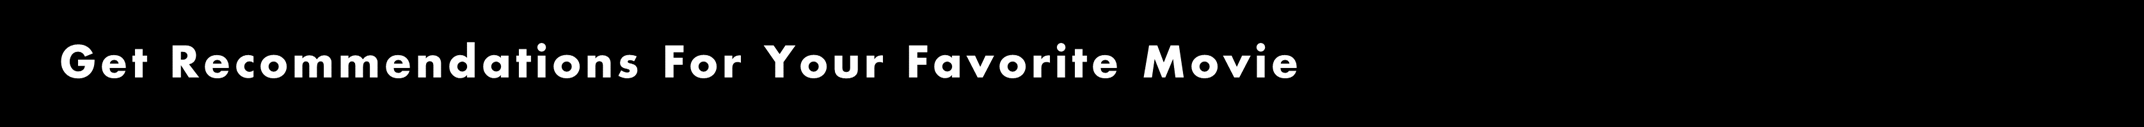

In [13]:
# Get movie_title from input
movie_title = input("Please enter the movie title: ")

# Call get_recommendations_by_title function with user_id
title_based_recommendations = get_recommendations_by_title(movie_title, recommender)

# Update column names and format combined_score as percentage
if title_based_recommendations is not None:
    title_based_recommendations = title_based_recommendations.rename(columns={'title': 'Movie Title', 'combined_score': 'Similarity'})
    title_based_recommendations['Your Personal Fit'] = title_based_recommendations['Similarity'].apply(lambda x: f"{x * 100:.2f}%")
    title_based_recommendations['Similarity'] = title_based_recommendations['Similarity'].apply(lambda x: f"{x:.2f}")
        
    # Reset index and display the DataFrame
    display_recommendations(combined_movie_recommendations[['Movie Title', 'Your Personal Fit', 'Similarity']].reset_index(drop=True))

Please enter the movie title:  daedpoool




Did you mean 'Deadpool (2016)'?

Recommendations based on the movie 'Deadpool (2016)':



Movie Title,Your Personal Fit,Similarity
Schindler's List (1993),98.08%,0.98
Team America: World Police (2004),93.84%,0.94
Big Fish (2003),88.56%,0.89
Eternal Sunshine of the Spotless Mind (2004),85.97%,0.86
"Pianist, The (2002)",84.43%,0.84
This Is Spinal Tap (1984),77.59%,0.78
"Counterfeiters, The (Die Fälscher) (2007)",75.91%,0.76
Dumb & Dumber (Dumb and Dumber) (1994),75.62%,0.76
Grave of the Fireflies (Hotaru no haka) (1988),69.42%,0.69
Beavis and Butt-Head Do America (1996),68.24%,0.68
